# Partie 2: construction d'un réseau de neurones de classification


## 1 - Imports

Pour pouvoir commencer, vous importerez les librairies suivantes:

In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd




## 2 - Loading the dataset avec tensorflow-dataset (tfds)

Pour charger les données, nous allons utiliser le projet tensorflow-dataset qui a le mérite de transformer directement les données en objet tf.data.Dataset que je souhaite vous voir utiliser pour différentes raisons exposées en cours Un grand nombre de projet/framework ou simple fichier excel ou csv peut être utilisé pour importer les données.

Le jeu de données MNIST est d'environ 12 MB.
The MNIST data-set is about 12 MB et sera téléchargé si il n'est pas trouvé dans le chemin par défaut. Le chemin par défaut est ~/tensorflow_datasets/mnist/3.0.1.

In [46]:
(ds_train, ds_test), ds_info = tfds.load(
                        'mnist',
                        split=['train', 'test'],
                        shuffle_files=True,
                        as_supervised=True,
                        with_info=True,
                        )

# check if data is a tf.data.Dataset object
assert isinstance(ds_train, tf.data.Dataset)
assert isinstance(ds_test, tf.data.Dataset)

print(ds_train)
print(ds_test)

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


## 3 - Analyse et préparation des données avec l'API tf.data.Dataset

Les données ont été chargées et regroupent 70.000 images associées à leur indice de chiffre manuscrit. Le jeu de données est déjà séparé en deux sous-ensembles mutuellement exclusifs.

### 3.1 - Caractéristiques du dataset
Dans cette section, analysez le dictionnaire ds_info pour renseigner les variables ci-dessous
- **Nombre d'exemples dans chaque ensemble**

In [47]:
print(ds_info)

''' START CODE HERE '''
num_examples_train =  ds_train.cardinality()
num_examples_test =  ds_test.cardinality()
''' END CODE HERE '''


print("Size of:")
print("- Training-set:\t\t{}".format(num_examples_train))
print("- Testing-set:\t\t{}".format(num_examples_test))


tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

Size of:
- Training-set:		60000
- Testing-set:		10000


- **Caractéristiques des entrées: dimension, nombre de canaux, nombre de classes, etc**

In [49]:
''' START CODE HERE '''

# shape of one image MNIST
img_shape = ds_info.features['image'].shape[0:2]

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = ds_info.features['image'].shape[2]
# Number of classes, one class for each of 10 digits.
num_classes = ds_info.features['label'].num_classes

''' END CODE HERE '''



print(img_shape)
print(num_channels)
print(num_classes)


(28, 28)
1
10


## 3.2 - Consume the dataset


L'API de `tf.data.Dataset` créé un itérable python ce qui le rend facile à utiliser pour obtenir les éléments de la base de données.

Voici comment on récupère le premier élément:

In [50]:
# Prendre le prochain element # créer explicitement un itérateur Python en utilisant iter et en consommant ses éléments en utilisant next :
elem = next(iter(ds_test))
image = elem[0].numpy()
label = elem[1].numpy()

print(image.shape)
print(label)
# print(image)


(28, 28, 1)
8


Affichez l'image avec le label correspondant dans le titre



' END CODE HERE '

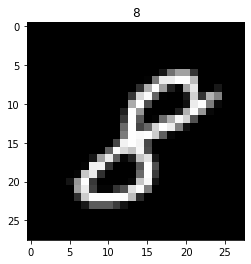

In [51]:
''' START CODE HERE '''
plt.figure()
if num_channels ==1:
    plt.imshow(image, cmap='gray')
else:
    plt.imshow(image)
plt.title(label)

''' END CODE HERE '''


## 3.3 - Prétraitement du dataset avec tf.data.Dataset API

L'API `tf.data.Dataset` permet de définir assez simplement des chaînes de traitements efficaces efficient. Ainsi, le schéma classique est :
- la création d'un dataset source à partir des données d'entrée (déjà fait ici);
- la définition et l'application de transformations du datasets pour prétraiter les données;
- l'itération sur le dataset et traiter tous les éléments (consume the dataset). 

L'itération fonctionne un peu comme un streaming, de telle manière que le dataset n'a pas besoin de tenir dans la mémoire de l'ordinateur ou dans celle du GPU.

### 3.3.1 - Normaliser tous les éléments
Pour cela, il suffit de créer une fonction `normalize_img` et d'utiliser la méthode `map` de l'objet `tf.data.Dataset`. La sortie représente un autre dataset dans lequel à chaque appel, à chaque itération sur l'objet la fonction `normalize_img` sera appliquée.

In [52]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test  = ds_test.map(normalize_img)


Ecrivez quelques commandes pour vérifier que la transformation a été faite.

In [53]:
''' START CODE HERE '''
for data in ds_train:
    #print(data)
    assert np.amax(data[0].numpy()) <= 1.0

for data in ds_test:
    #print(data)
    assert np.amax(data[0].numpy()) <= 1.0
''' END CODE HERE '''


' END CODE HERE '

### 3.3.2 - Mélanger les éléments de la base de données
Pour cela, il suffit d'utiliser la méthode `shuffle` de l'objet `tf.data.Dataset`. Il est utile de mélanger les exemples d'apprentissage pour la méthode de recueil/tri des données n'influence pas l'apprentissage. A noter qu'il est inutile de le faire sur la base de test.

In [54]:
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)


### 3.3.3 - Mise en batch des données

L'apprentissage des réseaux de neurones fonction par rétropropragation des gradients. Dans le cas des grandes bases de données, il est préférable de ne pas calculer les gradients sur toute la base de données d'apprentissage car le calcul pourrait être extrêment long et difficile à réaliser algorithmiquement. On préfère évaluer ce gradient sur une petite quantité de données mise en batch (de données). Le calcul des gradients est moins précis mais réalisé beaucoup plus souvent. Ce formalisme donne naissance à l'algorithme de descente de gradient stochastique (SGD). L'appel à la méthode `batch` de tensorflow fait cela.


In [55]:
batch_size = 100
ds_train = ds_train.batch(batch_size, drop_remainder=True)  # drop_remainder=False epresenting whether the last batch should be dropped in the case it has fewer than batch_size elements; the default behavior is not to drop the smaller batch.
ds_test = ds_test.batch(batch_size, drop_remainder=True) # drop_remainder=False epresenting whether the last batch should be dropped in the case it has fewer than batch_size elements; the default behavior is not to drop the smaller batch.


Ecrire quelques lignes de codes pour vérifier qu'on obtient bien un batch de taille `batch_size`

In [56]:
elem = next(iter(ds_test))
image = elem[0].numpy()
label = elem[1].numpy()
print(image.shape)
print(label.shape)


(100, 28, 28, 1)
(100,)


La fonction `plot_images` permet l'affichage de 9 éléments de la base de données. Executez là en changeant l'appel pour coller avec vos variables.

In [57]:
def plot_images(images, target_true, target_pred=None):
    assert images.shape[0] == target_true.shape[0] == 9
    #assert len(images) == len(target_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i, ..., 0], cmap='binary')

        # Show true and predicted classes.
        if target_pred is None:
            xlabel = "True: {0}".format(target_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(target_true[i], target_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

''' START CODE HERE '''
#TODO
''' END CODE HERE '''



' END CODE HERE '

## 4 - Créer et analyser le modèle de réseau de neurones avec Keras

La version 2 de Tensorflow intègre désormais Keras (`tf.keras`) facilitant notamment la création d'architecture pour les réseaux de neurones. 


### 4.1 Créer un réseau simple

L'architecture d'un réseau de neurones est définie par un empilement de couches de neurones. Dans Keras, un grand nombre de couches est possible ([layers possibles dans tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/)). On les découvrira au fur et à mesure. Dans ce TP, nous allons nous restreindre aux réseaux de neurones qu'on appelle `Dense` ou `fully connected` c'est à dire que tous les neurones d'une couche sont connectés à tous les neurones de la couche suivante. 

Cette couche `Dense` implemente l'opération: output = activation(dot(input, kernel) + bias). Cette couche Dense est caractérisée ([lien vers Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) notamment par:
 - un nombre de neurones;
 - le type d'activation appliqué à tous les neurones.
 Un aspect important est la méthode d'initialisation des poids et des biais qu'on explicitera plus tard.
 
Comme les entrées ont une structure spatiale (ce sont des images), et que les couches denses ne traitent pas la structure spatiale (nous verrons la semaine prochaine comment on traite les structures spatiales), il faut modifier les entrées par une couche appelée `Flatten` chargée de vectoriser les images.
Ainsi, un modèle à une couche dense prenant en entrée des images de shape: img_shape est défini par la fonction `tf.keras.Sequential`. Vous trouverez [ici](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) les différentes méthodes associés avec le modèle créé.


In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_shape),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# deuxième solution équivalente
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=img_shape))
# model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))


### 4.2 Evaluer les performances d'un modèle

Au cours de l'apprentissage, il est important d'évaluer les performances. La boucle d'évaluation suivante permet de faire cela pour l'accuracy. Vous noterez l'utilisation de la boucle sur les données de la base de test et des fonctions `tf.equal` et de `tf.reduce_mean`.


In [59]:
# performance du modèle
def eval_loop():
    # evaluating the model
    cor_pred = []
    accuracy_tot = []
    for i_batch, (img, target_label) in enumerate(ds_test):
        # mise en forme
        # img = tf.reshape(img, [batch_size, input_img_size])
        # target_labels = label  # tf.one_hot(label, num_classes)

        # logits = tf.matmul(img, weights) + biases
        target_pred = model(img, training=False)

        # Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.
        #
        # However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.
        # target_pred_ohe = tf.nn.softmax(logits)

        # The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.
        target_pred = tf.argmax(target_pred, axis=1)

        # performance measures
        correct_prediction = tf.equal(target_pred, target_label)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        cor_pred.append(correct_prediction)
        accuracy_tot.append(accuracy.numpy())

    print('model accuracy: {}'.format(np.mean(accuracy_tot)))
    # return accuracy_tot

#
eval_loop()


model accuracy: 0.06960000097751617


### 4.3 Visualiser les poids du réseau

En supplément de la performance, les poids du modèle peuvent également être tracés. 
Cette représentation donne des informations sur ce qui a été appris par la machine. 
La fonction `plot_weights_sequential` permet de faire cela.

2


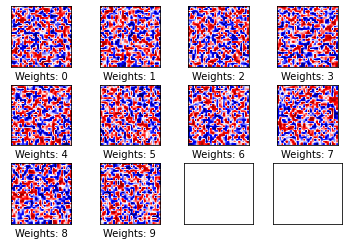

In [60]:
def plot_weights(weights, img_shape):

        # Get the lowest and highest values for the weights.
        # This is used to correct the colour intensity across
        # the images so they can be compared with each other.
        w_min = np.min(weights)
        w_max = np.max(weights)

        # Create figure with 3x4 sub-plots,
        # where the last 2 sub-plots are unused.
        fig, axes = plt.subplots(3, 4)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Only use the weights for the first 10 sub-plots.
            if i < 10:
                # Get the weights for the i'th digit and reshape it.
                # Note that w.shape == (img_size_flat, 10)
                image = weights[:, i].reshape(img_shape)

                # Set the label for the sub-plot.
                ax.set_xlabel("Weights: {0}".format(i))

                # Plot the image.
                ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove ticks from each sub-plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()


        
        
''' START CODE HERE '''
# Get the values for the weights from the TensorFlow variable.
weights = model.get_weights()
print(len(weights))
weights = weights[0]

''' END CODE HERE '''

# visualisation des poids
plot_weights(weights, img_shape[0:2])



Les poids positifs sont rouges et les poids négatifs sont bleus. Ces poids peuvent être intuitivement compris comme des filtres d'images. On verra plus tard l'évolution de ces poids le long de l'apprentissage.


## 5 - Définir la fonction de coût à optimiser

Pour que le modèle puisse mieux classer les images en entrée, nous devons d'une manière ou d'une autre modifier les variables pour les poids et les biais. Pour ce faire, il faut définir une fonction de coût mesurant l'adéquation entre la sortie prédite du modèle et à la sortie souhaitée.

L'entropie croisée est la fonction classiquement utilisée dans la classification pour actualiser les poids. L'objectif de l'optimisation est donc de minimiser l'entropie croisée afin qu'elle soit aussi proche de zéro que possible en modifiant les poids et les biais du modèle. Vous pouvez vous reporter [ici](https://www.tensorflow.org/api_docs/python/tf/keras/losses) pour voir les différentes fonctions déjà implémentées.

TensorFlow dispose d'une fonction intégrée pour calculer l'entropie croisée. Notez qu'elle utilise les valeurs des logits car il calcule également la softmax en interne.

Notre modèle calculera sa perte à l'aide de la fonction `tf.keras.losses.SparseCategoricalCrossentropy` qui prend les prédictions de probabilité de classe du modèle et l'étiquette souhaitée, et renvoie la perte moyenne à travers les exemples.
La fonction calculant les gradients est aussi donnée.


In [61]:
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_fcn(y_true=y, y_pred=y_)

l = loss(model, image, label, training=False)
print("Loss test: {}".format(l))


 # Utilisez le contexte tf.GradientTape pour calculer les gradients utilisés pour optimiser votre modèle:

def grad(model, inputs, targets):
    
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)





Loss test: 2.311572790145874


## 6 - Définir la méthode d'optimisation

Maintenant, il s'agit de définir un optimiseur qui va trouver le minimum de la fonction. Nous connaissons maintenant la descente de gradient stochastique qu'il s'agit de définir avec son `learning rate`.

Notez que l'optimisation ,'est pas faite à ce stade. En fait, on défit juste la fonction.



In [62]:
optimizer_fcn = tf.keras.optimizers.SGD(learning_rate=1.0)

def optimize(features, target_labels):

    # Compute the loss and the gradient
    loss_value, grads = grad(model, features, target_labels)

    # mise à jour des paramètres
    optimizer_fcn.apply_gradients(zip(grads, model.trainable_variables))

    # return gradients


Pour tester cette fonction, nous allons grâce à ce qui a été mis en place auparavant:
- optimiser une fois
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids 

Step: 1,         Loss: 2.2915079593658447
model accuracy: 0.16200000047683716


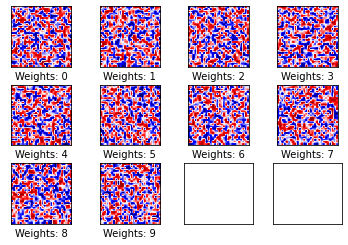

' END CODE HERE '

In [63]:
''' START CODE HERE '''
# Get a batch of (images, labels) from the training set
(img_batch, label_batch) = next(iter(ds_train))

# Call the optimize function
optimize(img_batch, label_batch)

# Evaluate the loss for each step
print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])
''' END CODE HERE '''


## 7 - Définir la boucle d'apprentissage

### 7.1 - Définir la boucle d'apprentissage avec Tensorflow

Une fois qu'on a défini tous les éléments, la boucle d'apprentissage est très simple.
Elle prend en entrée le nombre d'epochs `num_epochs`.

In [64]:
def train_loop(num_epochs):
    for epoch in range(0, num_epochs, 1):

        # Get a batch of training examples.
        # img_batch now holds a batch of images and
        # label_batch are the true labels for those images.
        (img_batch, label_batch) = next(iter(ds_train))

        # optimize
        optimize(img_batch, label_batch)

        print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))



Faites tourner cette fonction pour une epoch et analyser les résultats comme auparavant:
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids 


Step: 3,         Loss: 2.25053071975708
model accuracy: 0.21889999508857727


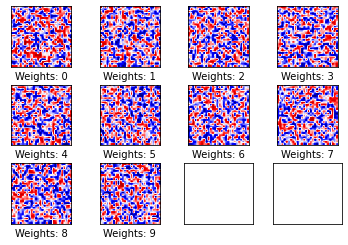

' END CODE HERE '

In [67]:
num_epochs = 1


''' START CODE HERE '''
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])
''' END CODE HERE '''

Refaites tourner cette fonction pour 10 epoch et analyser les résultats comme auparavant:
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids 


Step: 4,         Loss: 2.2310383319854736
Step: 5,         Loss: 2.211796760559082
Step: 6,         Loss: 2.197286605834961
Step: 7,         Loss: 2.14831280708313
Step: 8,         Loss: 2.1441683769226074
Step: 9,         Loss: 2.1219472885131836
Step: 10,         Loss: 2.102113723754883
Step: 11,         Loss: 2.061441421508789
Step: 12,         Loss: 2.0406196117401123
Step: 13,         Loss: 2.0068817138671875
model accuracy: 0.5317000150680542


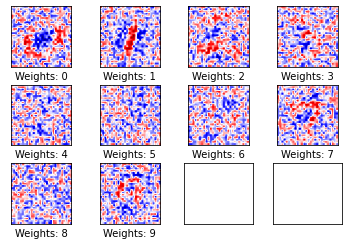

In [68]:
num_epochs = 10


''' START CODE HERE '''
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])

### 7.2 - Keras offre la possibilité de simplifier la démarche

En fait, l'API Keras facilite aussi le code de toutes ces étapes. Après avoir défini, l'architecture du modèle avec `Sequential`. Vous devrez le compiler avec la méthode `compile` en choisissant la fonction de coût, l'optimiseur et la métrique de performance.


In [69]:
model.compile(
              loss=loss_fcn, 
              optimizer=optimizer_fcn, 
              metrics=[tf.keras.metrics.sparse_categorical_accuracy]
             )


L'apprentissage sur un nombre d'epochs se fera par un simple appel à la méthode `.fit`.
Elle permet de définir un ensemble de validation sur lequel on vient estimer les performances de généralisation.

In [70]:
num_epochs = 100
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_test)

Epoch 1/100
600/600 [==============================] - 1s 2ms/step - loss: 1.6350 - sparse_categorical_accuracy: 0.8679 - val_loss: 1.5772 - val_sparse_categorical_accuracy: 0.9075
Epoch 2/100
600/600 [==============================] - 1s 1ms/step - loss: 1.5752 - sparse_categorical_accuracy: 0.9062 - val_loss: 1.5621 - val_sparse_categorical_accuracy: 0.9172
Epoch 3/100
600/600 [==============================] - 1s 1ms/step - loss: 1.5648 - sparse_categorical_accuracy: 0.9116 - val_loss: 1.5565 - val_sparse_categorical_accuracy: 0.9181
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 1.5590 - sparse_categorical_accuracy: 0.9155 - val_loss: 1.5520 - val_sparse_categorical_accuracy: 0.9219
Epoch 5/100
600/600 [==============================] - 1s 1ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.9180 - val_loss: 1.5494 - val_sparse_categorical_accuracy: 0.9224
Epoch 6/100
600/600 [==============================] - 1s 1ms/step - loss: 1.5524 - sparse_cate

Le modèle peut alors être sauver dans un fichier (selon deux formats) et éventuellement recharger par la suite.

In [71]:
# Saving and Restoring the model
# architecture and weights
model.save("my_keras_model.h5")
model = keras.models.load_model("my_keras_model.h5")

# weights only
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")



Une fois le modèle appris, la méthode `predict` permet de le prédire sur toutes les données de `ds_test`.

In [72]:
target_pred = model.predict(ds_test)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()
print(target_label_pred.shape)

(10000,)


## 8 - Analyser les résultats
Une fois le modèle appris, il s'agit de recenser tous les résultats en affichant (et en les commentant!!!!):
 - les learning curves;
 - les métriques de performance;
 - les poids et les gradients;
 - les erreurs de classification.

### 8.1 learning curves and accuracies

Deux possibilités existent pour les métriques de performance:
- soit la méthode `evaluate` de Keras
- soit la fonction `eval_loop()`

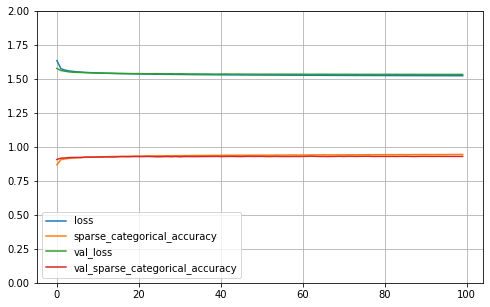

100/100 [==============================] - 0s 4ms/step - loss: 1.5332 - sparse_categorical_accuracy: 0.9302
{'loss': 1.5332131385803223, 'sparse_categorical_accuracy': 0.9301999807357788}
model accuracy: 0.9301999807357788


In [73]:
# learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)  # set the vertical range to [0-1]
plt.show()

# métriques de performance:


result = model.evaluate(ds_test)
print(dict(zip(model.metrics_names, result)))

eval_loop()




**Question:** Commenter ces métriques de performances?

On remarque que les metrique se stabilise très rapidement 5-10 boucle d'aprentissage (0.93 accuratie, 1.53 loss) 

## 8.2 - Examiner les poids et les gradients

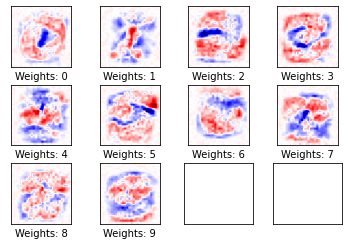

In [74]:
# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])


Les poids positifs sont en rouge et en bleu pour les négatifs. Par exemple, les poids utilisés pour déterminer si une image montre un chiffre zéro ont une réaction positive (rouge) à une image d'un cercle, et ont une réaction négative (bleu) aux images dont le contenu se trouve au centre du cercle.

De même, les pondérations utilisées pour déterminer si une image montre un chiffre 1 réagissent positivement (rouge) à une ligne verticale au centre de l'image, et réagissent négativement (bleu) aux images dont le contenu se trouve autour de cette ligne.

Notez que les poids ressemblent surtout aux chiffres qu'ils sont censés reconnaître après quelques itérations. Après un entraînement sur plusieurs milliers d'images, les poids deviennent plus difficiles à interpréter car ils doivent reconnaître de nombreuses variations de la façon dont les chiffres peuvent être écrits.

### 8.3 - Afficher les erreurs de classification


In [75]:
target_pred = model.predict(ds_test)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()


**Plotting example errors**

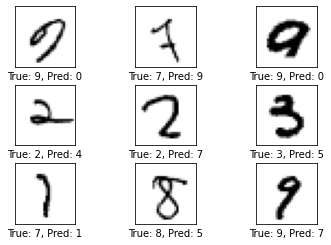

In [76]:
tmp = [target_label_actual for (img, target_label_actual) in ds_test]

target_label_actual = []
[ target_label_actual.extend(el.numpy()) for el in tmp]
target_label_actual = np.array(target_label_actual)

tmp = [img for (img, target_label_actual) in ds_test]
imgs = []
[ imgs.extend(el.numpy()) for el in tmp]
imgs = np.array(imgs)

uncorrect = np.where(target_label_pred != target_label_actual)[0]
uncorrect = uncorrect[0:9] # juste pour le display
plot_images(imgs[uncorrect,:,:,:], target_label_actual[uncorrect], target_pred=target_label_pred[uncorrect])


# Partie 3: application à la classification de fonds marins


Dans la suite, vous êtes chargé d'appliquer la démarche décrite dans la partie 2 aux données des images sonar de fonds marins rencontrés précédemment.

Si vous ne savez pas commencer, le script ci-dessous pourra certainement vous aider à démarrer.


In [78]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/imgs/'
    LABEL_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/labels/labels.csv'
else:
    IN_COLAB = False
    DATASET_PATH = r'./dataset/imgs/'
    LABEL_PATH = r'./dataset/labels/labels.csv'

# Charger le fichier CSV
dataset_df = pd.read_csv(LABEL_PATH)
dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)


# Charger les images
images = np.array([plt.imread(img) for img in dataset_df['image_path'].values.tolist()])
label_names = dataset_df['seafloor'].to_numpy()

# Création du dataset en objet tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((images, label_names))



    